In [2]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import display, Markdown, Latex

In [23]:
# TODO:
# insert hypotesis verification in more or less every method
# method to see if the gradients method converges (s.p.d)
# comment the code
# system all the workflow

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [4]:
def finDif(omega,f,n,bc):
    """
    Return the mass matrix for the finite difference approximation of the prblem -u_{xx}(x) = f(x).
    
    Parameters
    ----------
    omega : list
        Interval of the problem. It is a list of two elements, where omega[0] is the lower bound of the interval and
        omega[1] is the upper bound of the interval.
    f : function
        Forcing function of the problem
    n : integer
        Number of discretization points
    bc : list
        Boundary conditions of the problem. It is a list of two elements containing the values of the boundary conditions
        
    Returns
    -------
    out : tuple
        Tuple containing the matrix and the known-term vector
    """
    
    A = zeros((n,n))
    b = zeros(n)
    h = (omega[1] - omega[0]) / (n - 1)
    discr_points = [i * h for i in range(n)]
    
    b[0], b[1] = bc
     
    A = diag(ones(n-2),-2) + diag(-16*ones(n-1),-1) + diag(30*ones(n)) + diag(-16*ones(n-1),1) + diag(ones(n-2),2)
    
    f = vectorize(f)
    b[1:n-1] = f(discr_points[1:n-1])
    
    return A / (12*(h)**2), b

Call the function using:

In [5]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

A[0,:] = zeros(n)
A[-1,:] = zeros(n)
A[0,0] = A[-1,-1] = 1

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [6]:
def LU(A, pivoting = True):
    """
    Return the LU factorization of the system matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the factorization.
        
    Returns
    -------
    out : tuple
        Tuple containing two elements: the lower-triangular matrix and the upper-trinagular matrix computed by the
        LU factorization.
    """
    
    n = len(A)
    L = zeros((n,n), dtype=float)
    U = A.copy().astype(float)
    P = eye(n)
    
    for k in range(n):
        if pivoting and U[k,k] == 0 and k < n-1:
            for w in range(k+1,n):
                if U[w,w] != 0:
                    U[[k,w]] = U[[w,k]]
                    L[[k,w]] = L[[w,k]]
                    P_temp = eye(n)
                    P_temp[[k,w]] = P_temp[[w,k]]
                    P = dot(P,P_temp)
    
        L[k+1:n,k] = U[k+1:n,k] / U[k,k]
        for i in range(k+1,n):
            for j in range(k,n):
                U[i,j] -= L[i,k] * U[k,j]
    fill_diagonal(L,1)
    
    if pivoting:
        return L, U, P
    
    return L, U

L, U, P = LU(A)

In [7]:
ex = array([[1,2,3],\
            [2,4,5],\
            [7,8,9]])
L, U, P = LU(ex)
allclose(P.dot(ex),L.dot(U))

True

In [8]:
def cholesky(A):
    """
    Return the Cholesky factorization of the system matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the factorization.
        The matrix must be symmetric and positive definite.
        
    Returns
    -------
    out : tuple
        Tuple containing two elements: the lower-triangular matrix and the upper-trinagular matrix computed by the
        Cholesky factorization (one is the transpose of the other).
    """
    
    assert allclose(A, A.T), "The matrix is not symmetric"
    
    n = len(A)
    L = zeros((n,n), dtype=float)
    
    L[0,0] = A[0,0]**.5
    for j in range(1,n):
        for i in range(0,j):
            L[i,j] = (A[j,i] - sum(L[:i,j]*L[:i,i])) / L[i,i]
    
        L[j,j] = (A[j,j] - sum(L[:j,j]**2))**.5

    return L.transpose(), L

HT, H = cholesky(A)

allclose(A,HT.dot(H))

AssertionError: The matrix is not symmetric

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [9]:
def L_solve(L,rhs):
    """
    Return the solution of a system of equations with lower-triangular matrix, using forward substitution algorithm.
    
    Parameters
    ----------
    L : numpy.array
        2-d numpy.array representing the upper triangular matrix.
    P : numpy.array
        2-d numpy.array representing the pivoting matrix
    rhs : numpy.array
        1-d numpy array representing the known-term vector of the system.
    
    Returns
    -------
    out : numpy.array
        The solution of the system.
    """
    x = zeros_like(rhs).astype(float)
    n = len(rhs)
    
    x[0] = rhs[0] / L[0,0]
    for i in range(1,n):
        x[i] = (rhs[i] - dot(L[i,:i],x[:i])) / L[i,i]
    
    return x

In [10]:
def U_solve(U,rhs):
    """
    Return the solution of a system of equations with upper-triangular matrix, using backward substitution algorithm.
    
    Parameters
    ----------
    L : numpy.array
        2-d numpy.array representing the upper triangular matrix.
    rhs : numpy.array
        1-d numpy array representing the known-term vector of the system.
    
    Returns
    -------
    out : numpy.array
        The solution of the system.
    """
    x = zeros_like(rhs).astype(float)
    n = len(rhs)
    
    x[-1] = rhs[-1] / U[-1,-1]
    for i in range(n-1,-1,-1):
        x[i] = (rhs[i] - dot(U[i,i+1:],x[i+1:])) / U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

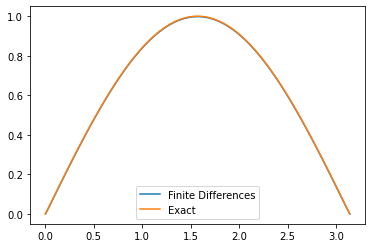

In [11]:
def solve_system(A, b, pivoting = True):
    """
    Return the solution of a system of equations using the LU factorization and then the forward and backward substitution
    algorithms.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix of the system.
    rhs : numpy.array
        1-d numpy array representing the known-term vector of the system.
    pivoting : boolean, optional
        True if the LU factorization is computed with pivoting
    
    Returns
    -------
    out : numpy.array
        The solution of the system.
    """
    
    if pivoting:    
        L, U, P = LU(A)
        b = P.dot(b)
        
    else:
        L, U = LU(A, pivoting = False)
        
    y = L_solve(L, b)
    x = U_solve(U, y)
    
    return x

u = solve_system(A,b)
allclose(A.dot(u), b)
discr_points = linspace(omega[0],omega[1],n)
x = linspace(omega[0],omega[1])
plot(discr_points,u, label="Finite Differences")
plot(x,f(x), label="Exact")
_ = legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

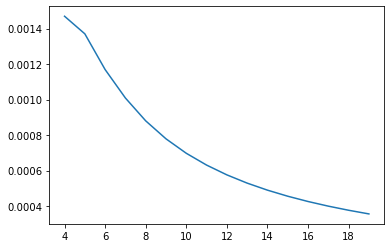

In [12]:
omega = [0,1]
f = lambda x : x*(1. - x)
bc = [0,0]
exact = lambda x : x**4/12 - x**3/6 + x/12

errors = []

for n in range(4,20):
    A,b = finDif(omega,f,n,bc)
    A[0,:] = zeros(n)
    A[-1,:] = zeros(n)
    A[0,0] = A[-1,-1] = 1
    
    u = solve_system(A,b)
    discr_points = linspace(omega[0],omega[1],n)
    
    error = max(abs(exact(discr_points) - u))
    errors.append(error)

_ = plot(range(4,20),errors)
#x = linspace(omega[0],omega[1])
#plot(discr_points,u, label="Finite Differences")
#plot(x,exact(x), label="Exact")
#_ = legend()

In [13]:
out = "| Grid points | Errors |\n|:---|:---|"
for i in range(4,20):
    out += "\n|" + str(i) + " | " + str(round(errors[i-4],8)) +  "|"
display(Markdown(out))

| Grid points | Errors |
|:---|:---|
|4 | 0.00146972|
|5 | 0.00137061|
|6 | 0.00116923|
|7 | 0.0010089|
|8 | 0.00088022|
|9 | 0.00077894|
|10 | 0.00069752|
|11 | 0.00063105|
|12 | 0.00057586|
|13 | 0.00052938|
|14 | 0.00048974|
|15 | 0.00045555|
|16 | 0.00042578|
|17 | 0.00039962|
|18 | 0.00037647|
|19 | 0.00035583|

Compute the inverse of the matrix A exploiting the derived LU factorization

In [14]:
def inverse(A):
    """
    Return the inverse of the matrix, using the LU factorization.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix to invert.
    
    Returns
    -------
    out : numpy.array
        2-d numpy.array representing the inverse of the matrix.
    """
    
    n = len(A)
    inv_cols = []
    
    for i in range(n):
        e_i = array([[1 if k == i else 0] for k in range(n)])
        inv_cols.append(solve_system(A,e_i))
        
    return column_stack(inv_cols)

A_inv = inverse(A)

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [15]:
def condNumb(A):
    """
    Return the condition number of the matrix, considering the l-infinity norm.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to calculate the condition number.
    
    Returns
    -------
    out : integer
        The condition number of the matrix.
    """
    
    A_inv = inverse(A)
    n = len(A)
    
    assert allclose(A.dot(A_inv),eye(n)), "Trubles when computing the inverse of the matrix."
    
    l_infty_norm     = max([sum(abs(A[i,:])) for i in range(n)])
    l_infty_norm_inv = max([sum(abs(A_inv[i,:])) for i in range(n)])
    
    return l_infty_norm * l_infty_norm_inv

condNumb(A)

2073.7421848409094

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [22]:
# Hypotesis: real eigenvalues
def gershgorin(A):
    """
    Return the set of gershgorin circles of the matrix; for every diagonal element, the radius of the corresponding circle
    is the minimum between the radius of the row and column circle.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to calculate the gershgoring circles.
    
    Returns
    -------
    out : list
        List of lists of two elements. The first element is the centre and the second is the radius of the circle.
    """
    
    n = len(A)
    circles = []
    
    # Row circles
    for i in range(n):
        radius = sum([abs(A[i,j]) if j != i else 0 for j in range(n)])
        circles.append([A[i,i],radius])
    
    # Columns circles
    for j in range(n):
        radius = sum([abs(A[i,j]) if i != j else 0 for i in range(n)])
        circles[j][1] = min(circles[j][1], radius)
          
    return circles

def eig_ranges(A):
    """
    Return a list containing the indexes of the connected components of the union of the gershgorin circles.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix.
    
    Returns
    -------
    out : list
        List of lists. Every element represents a connected component of the union, and contains the indexes of the list of
        circles that belong to that component.
    """
    circles = gershgorin(A)
    n = len(A)
    union = [[0]]
    
    circles = sorted(circles, key=lambda x:x[0]) # Sorted according to the center

    for i in range(1,n):
        prev_circ_right_boundary = circles[i-1][0] + circles[i-1][1]
        cur_circ_left_boundary = circles[i][0] - circles[i][1]
        if(prev_circ_right_boundary > cur_circ_left_boundary):
            for j in range(len(union)):
                if i-1 in union[j]:
                    union[j].append(i)
        else:
            union.append([i])
            
    return union, circles

def shifted_power_method(A,shift=0,epsilon = 1e-8,max_iter = 1e4):
    """
    Return the eigenvalue of the matrix A computed with the shifted power method, using a given shift.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix.
    shift : float, optional
        the shift of the power method; default is 0 (standard power method)
    epsilon : float, optional
        threshold of the distance between two eigenvalues computed in two subsequent iterations; default is 1e-8
    max_iter : integer, optional
        maximum number of iterations, deafult is 1e4
    
    Returns
    -------
    out : integer
        Eigenvalue computed with the shifted power method.
    """
    
    n = len(A)
    A_shift = A - shift*eye(n)
    A_shift_inverse = inverse(A_shift)
        
    assert allclose(A_shift.dot(A_shift_inverse),eye(n)), "Trubles when computing the inverse of the matrix."
    
    x = ones(n)
    y = x / linalg.norm(x)
    err = 1
    n_iter = 0
    eig_prec = 0
    eig_cur = 0
    
    while n_iter < max_iter and err > epsilon * eig_cur:
    
        x = A_shift_inverse.dot(y)
        y = x / linalg.norm(x)
        eig_cur = 1./(dot(y.dot(A_shift_inverse),y))
        
        err = abs(eig_cur - eig_prec)
        eig_prec = eig_cur
        n_iter += 1
        
    return eig_cur + shift

def eigenvalues(A, epsilon = 1e-8, max_iter = 1e4):
    """
    Return all the real eigenvalues of the matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the eigenvalues.
    epsilon : float, optional
        threshold of the distance between two eigenvalues computed in two subsequent iterations; default is 1e-8
    max_iter : integer, optional
        maximum number of iterations for every eigenvalue to compute, deafult is 1e4
    
    Returns
    -------
    out : integer
        Eigenvalue computed with the shifted power method.
    """
    
    ranges, circles = eig_ranges(A)
    eigenvalues = []
    
    for interval in ranges:        
        for i in range(len(interval)):
            center = circles[interval[i]][0]
            shift = random.normal(loc = center)
            eigenvalues.append(shifted_power_method(A, shift, epsilon, max_iter))
    
    return eigenvalues

ex = np.array([[10,-1,0,1],\
               [0.2,8,0.2,0.2],\
               [1,1,2,1],\
               [-1,-1,-1,-11]])

res = eigenvalues(ex)
res

[-10.869101659671902, 1.89948876031966, 8.147824458507918, 9.821788440621901]

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

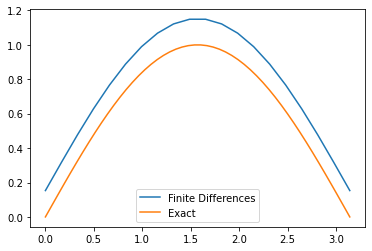

In [149]:
def conjugate_gradient(A, b, P, nmax=1e6, eps=1e-10):
    """
    Return the result of a preconditioned conjugant gradient method.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to, approximately, solve the linear system.
    b : numpy.array
        array of known terms of the system (rhs vector).
    P : numpy.array
        2-d numpy.array representing the preconditioner of the method.
    nmax : integer, optional
        maximum number of iterations of the method; default is len(A).
    eps : float, optional
        threshold of the error between the residuals of two subsequent iterations; default is 1e-10.
    
    Returns
    -------
    out : numpy.array
        The approximate solution of the linear system.
    """
    
    # assert A is s.p.d
    #assert allclose(A, A.T), "The matrix is not symmetric"
    
    A = array(A, dtype="float")
    b = array(b, dtype="float")
    
    n = len(A)
    x = ones(n)
    r = b - A.dot(x)
    z = solve_system(P,r)
    p = z
    n_iter = 0
    
    while n_iter < nmax and linalg.norm(r) > eps:
        alpha = dot(p,r) / dot(A.dot(p),p)
        x = x + alpha * p
        r = r  - alpha*A.dot(p)
        z = solve_system(P,r)
        beta = dot(z,A.dot(p)) / dot(p,A.dot(p))
        p =  z - beta*p
        
        n_iter += 1
    
    return x

omega = [0,pi]
f = lambda x : sin(x)
n = 20
bc = [0,0]
A, b = finDif(omega, f, n, bc)

#A[0,:] = zeros(n)
#A[-1,:] = zeros(n)
#A[0,0] = A[-1,-1] = 1

u = conjugate_gradient(A,b, diag(A)*eye(n))
allclose(A.dot(u), b)

discr_points = linspace(omega[0],omega[1],n)
x = linspace(omega[0],omega[1])
plot(discr_points,u, label="Finite Differences")
plot(x,f(x), label="Exact")
_ = legend()

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
def backward_euler(omega, ic, f, num_discr_points):
    """
    Return the numerical approximation of the given Cauchy problem.
    
    Parameters
    ----------
    omega : list
        List of two elements; the first is the lower bound of the interval of the problem,
        the second is the upper bound of the interval.
    ic : float
        Initial condition of the problem.
    f : function
        Forcing function of the problem.
    num_discr_points : integer
        Number of discretization points to use in the approximation.
    
    Returns
    -------
    out : numpy.array
        The approximate solution of the Cauchy problem; the len(out) = discr_points.
    """
    
    u = zeros(num_discr_points)
    discr_points = linspace(omega[0],omega[1],num_discr_points)
    
    u[0] = ic
    
    
    

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO